Coefficients and Kernel vs. Kernel Derivative Contributions

In [239]:
import trig_poly
import dual_certificates
import test_data
import numpy as np
import plt_util
import phase_transition
from matplotlib import pyplot as plt

%matplotlib inline

In [380]:
reload(test_data)
reload(dual_certificates)
reload(trig_poly)

m = 25
fc = 15
min_separation = 0.55 / fc
N = int(1.0 / min_separation) - 6

print N, m
print min_separation
print ''

kernel = trig_poly.TrigPoly.dirichlet(fc)

support = test_data.jittered_supports(N, min_separation=min_separation, jitter_factor=2, jitter_ratio=1.0)
sign_pattern = test_data.uniform_sign_pattern_multidim(N, m, sparse=False)

21 25
0.0366666666667



In [381]:
support.shape, sign_pattern.shape

((21,), (21, 21))

In [382]:
sign_pattern = np.identity(N)

In [383]:
interpolator = dual_certificates.interpolate_multidim_l2_min(support, sign_pattern, kernel)
interpolator_no_deriv = dual_certificates.interpolate_multidim_only_kernel(support, sign_pattern, kernel)

In [378]:
reload(test_data)
reload(dual_certificates)
reload(trig_poly)

m = 25
fc = 15
min_separation = 0.75 / fc
N = int(1.0 / min_separation) - 5

print N, m
print min_separation
print ''

k = 10
kernel = trig_poly.TrigPoly.multi_dirichlet(fc, [1.0 / k] * k)
kernel_deriv = kernel.derivative()
kernel_deriv_2 = kernel_deriv.derivative()
print kernel_deriv_2(0)[0].real

support = test_data.jittered_supports(N, min_separation=min_separation, jitter_factor=2, jitter_ratio=1.0)
sign_pattern = np.array(np.array([kernel_deriv(tj) for tj in support]).flat)

interpolator_1d = dual_certificates.interpolate(support, sign_pattern, kernel)

15 25
0.05

-263.1894506957161


(0, 0.02)

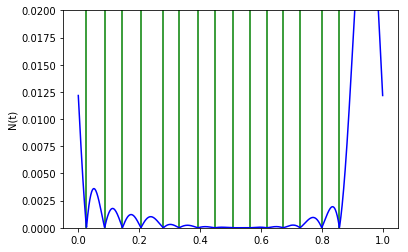

In [379]:
plt_util.plot_trig_poly_magnitude((interpolator_1d + kernel_deriv * (-1.0)) * (1.0 / kernel_deriv_2(0)[0].real), points=1000)
plt_util.plot_support_magnitude_lines(support)

plt.gca().set_ylim(0, 0.02)

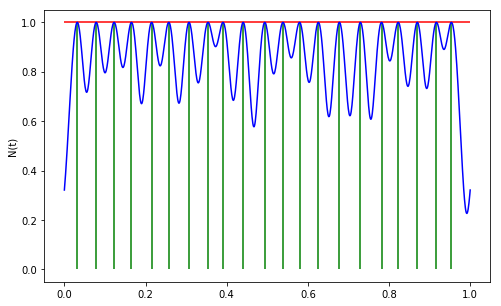

In [384]:
plt.subplots(figsize=(8,5))

plt_util.plot_trig_poly_magnitude(interpolator, points=1000)
plt_util.plot_support_magnitude_lines(support)
plt_util.plot_magnitude_bounds()

# plt.gca().set_ylim(0.95, 1.01)

In [385]:
print dual_certificates.validate(support, sign_pattern, interpolator)
print dual_certificates.validate(support, sign_pattern, interpolator_no_deriv)

{'status': True, 'max_deviation': 3.0530660597898076e-13, 'values_achieved': True, 'bound_achieved': True}
{'status': False, 'max_deviation': 1.9897550499697763e-15, 'values_achieved': True, 'bound_achieved': False}


In [386]:
def kernel_matrix(kernel, support):
    shifted_supports = np.outer(np.ones(N), support) - np.outer(support, np.ones(N))
    return kernel.eval(shifted_supports).real

In [387]:
K0 = kernel_matrix(kernel, support)
K1 = kernel_matrix(kernel.derivative(), support)
K2 = kernel_matrix(kernel.derivative().derivative(), support)

K0_inv = np.linalg.inv(K0)

In [388]:
beta = np.diag(np.linalg.solve(K0, K1)) / np.diag(K2 - np.dot(K1, np.linalg.solve(K0, K1)))
d_beta_V = np.dot(np.diag(beta), sign_pattern)

In [430]:
beta

array([ 1.87897077e-04, -3.75067688e-04, -1.74505313e-04,  9.81479361e-04,
       -1.07061344e-03,  9.76318621e-04, -5.17905312e-04, -1.70433996e-04,
        7.93608766e-04,  1.20511526e-04, -7.77270348e-04, -2.46258548e-04,
        4.90504560e-04,  4.39609405e-04, -5.10745146e-05,  2.19726723e-04,
       -1.19445871e-03,  6.29578768e-04,  3.87146539e-05, -7.21825579e-04,
        4.93205171e-04])

In [389]:
K0_inv_max_eval = np.max(np.linalg.eigvalsh(K0_inv))

In [425]:
kernel_deriv = kernel.derivative()

ts = np.linspace(0, 1, 1000)
values_1 = []
values_2 = []
values_2_weak = []
values_triangle = []
values_triangle_weak = []
values = []
inner_product_terms = []

for t in ts:
    k0t = np.array([kernel(t - tj) for tj in support])
    k1t = np.array([-kernel_deriv(t - tj) for tj in support])
    
    K0_inv_k0t = np.linalg.solve(K0, k0t)
    
    qt_1 = np.dot(K0_inv_k0t.T, sign_pattern)
    # qt_1 = np.dot(K0_inv_k0t.T, sign_pattern)
    qt_2 = np.dot((k1t - np.dot(K1.T, K0_inv_k0t)).T, d_beta_V)
    
    inner_product_terms.append(np.inner(qt_1, qt_2)[0][0])
    
    values_2_weak.append(np.max(np.absolute(beta)) * np.linalg.norm(k1t - np.dot(K1, K0_inv_k0t)))
    
    # qt = qt_1 + qt_2
    
    values_1.append(np.linalg.norm(qt_1))
    values_2.append(np.linalg.norm(qt_2))
    values_triangle.append(np.linalg.norm(qt_1) ** 2 + np.linalg.norm(qt_2) ** 2)
    values_triangle_weak.append(np.linalg.norm(qt_1) + values_2_weak[-1])
    
    values.append(np.linalg.norm(qt_1 + qt_2))
    # values.append(np.linalg.norm(interpolator(t)))

(0.95, 1.01)

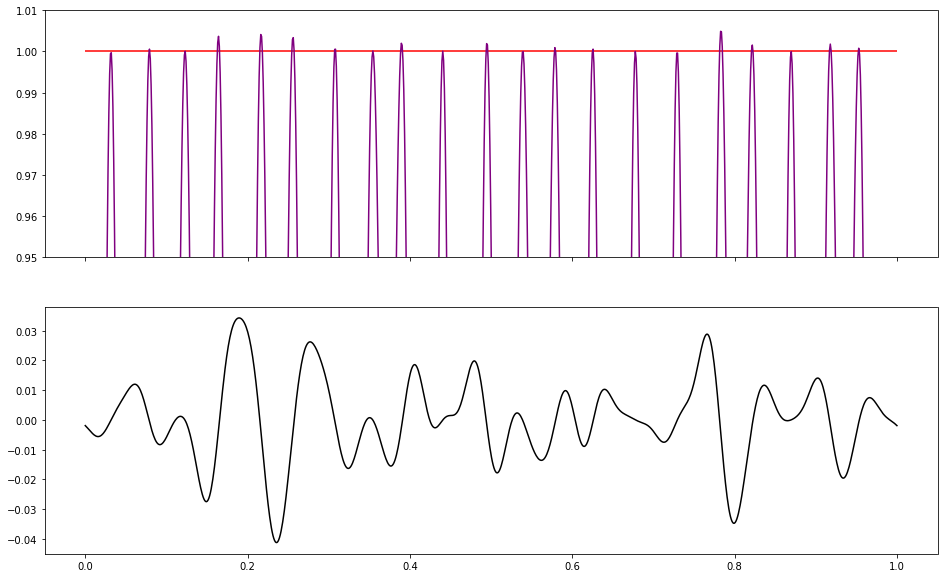

In [429]:
reload(plt_util)

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(16,10))

# plt.plot(ts, values, c='blue', alpha=1)
axes[0].plot(ts, np.array(values_triangle), c='purple')
# axes[0].plot(ts, np.array(values), c='purple')
# plt.plot(ts, values_triangle_weak, c='pink')

# plt.plot(ts, values_1, c='orange', alpha=0.7)
# plt.plot(ts, values_2, c='pink', alpha=1)

axes[1].plot(ts, np.array(inner_product_terms), c='black')

# plt_util.plot_support_magnitude_lines(support)
plt_util.plot_magnitude_bounds(ax=axes[0])

axes[0].set_ylim(0.95, 1.01)
# axes[0].set_xlim(0.7, 0.9)


In [36]:
kernel_coeffs, kernel_derivative_coeffs = dual_certificates.interpolate_multidim_l2_min(
    support, sign_pattern, kernel, return_coeffs=True)

In [171]:
for i in range(m):
    print np.mean(np.abs(sign_pattern[:, i] - kernel_coeffs[i]))

0.659252260945
0.185338242012
0.925454752577
0.455503425395
0.21065408922
0.36881505587
0.351274794313
0.284042332942
1.41711480006
0.454358178649


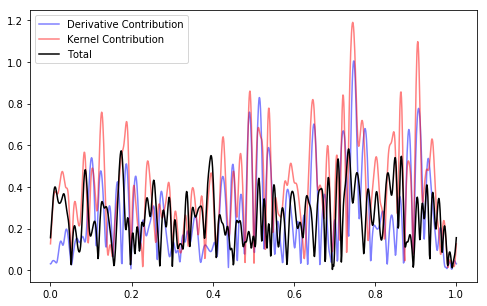

In [172]:
reload(plt_util)

plt.subplots(figsize=(8, 5))

m = 5

kernel_contrib = sum(
    (kernel.shift(-t) * kernel_coeffs[m][i] for i, t in enumerate(support)),
    trig_poly.TrigPoly.zero())
kernel_derivative_contrib = sum(
    (kernel.derivative().shift(-t) * kernel_derivative_coeffs[m][i] for i, t in enumerate(support)),
    trig_poly.TrigPoly.zero())

plt_util.plot_trig_poly_magnitude(kernel_derivative_contrib, label='Derivative Contribution', points=1000, alpha=0.5)
plt_util.plot_trig_poly_magnitude(kernel_contrib, c='red', label='Kernel Contribution', points=1000, alpha=0.5)
plt_util.plot_trig_poly_magnitude(kernel_contrib + kernel_derivative_contrib, c='black', label='Total', points=1000, alpha=1.0)
plt.legend()